# 6.1 이미지 분류를 위한 신경망
## 목차
### 6.1.1 LeNet-5
### 6.1.2 AlexNet
### 6.1.3 VGGNet
### 6.1.4 GoogLeNet
### 6.1.5 ResNet

## 6.1 LeNet-5
- convolution, sub-sampling을 반복적으로 거치면서 마지막 fully connected layer에서 분류 수행

In [1]:
import torch
import copy
import torchvision
from torch.utils.data import DataLoader, Dataset,random_split
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

- dogs-vs-cat train,val,test 데이터셋 셋팅

In [2]:
cat_dir_path = r"./080289/chap06/data/dogs-vs-cats/Cat/"
dog_dir_path = r"./080289/chap06/data/dogs-vs-cats/Dog/"

cat_image_path_list = sorted(
    [ os.path.join(cat_dir_path,cat_image_name) for cat_image_name in os.listdir(cat_dir_path)]
)
dog_image_path_list = sorted(
    [ os.path.join(dog_dir_path,dog_image_name) for dog_image_name in os.listdir(dog_dir_path)]
)
total_image_path_list = [*cat_image_path_list,*dog_image_path_list]
correct_image_path_list = [
    image_file_path for image_file_path in total_image_path_list if cv2.imread(image_file_path) is not None
]

random.seed(42)
random.shuffle(correct_image_path_list )
train_images_filepaths = correct_image_path_list[:400]
val_images_filepaths = correct_image_path_list[400:-10]
test_images_filepaths = correct_image_path_list[-10:]
print(
    f"train 데이터 개수 : {len(train_images_filepaths)}"
    f"\ntest 데이터 개수 : {len(val_images_filepaths)}"
    f"\nval 데이터 개수 : {len(test_images_filepaths)}"
)

train 데이터 개수 : 400
test 데이터 개수 : 92
val 데이터 개수 : 10


- test 이미지 확인

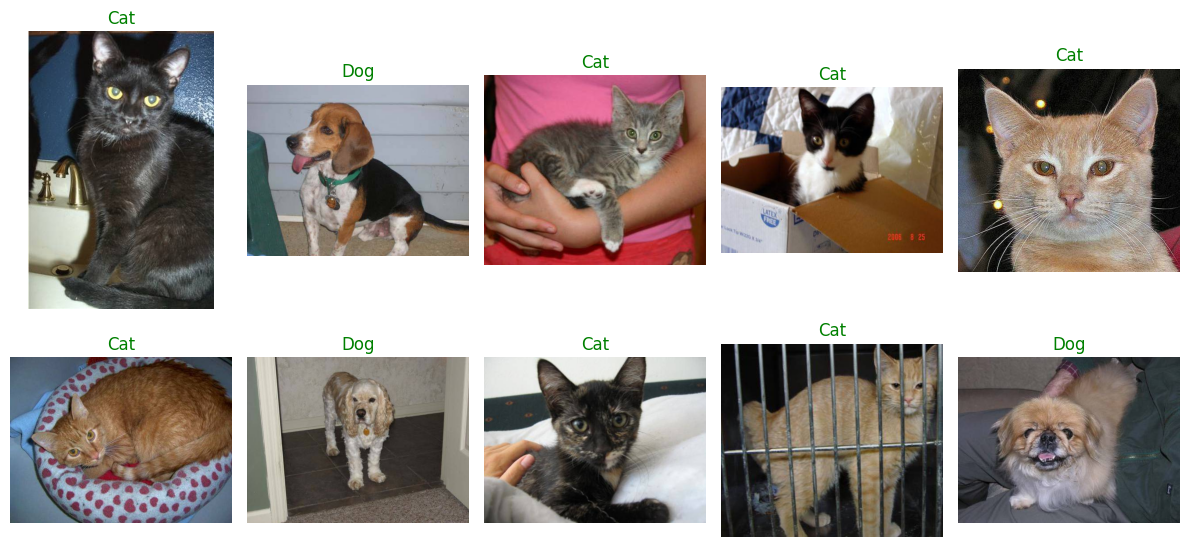

In [3]:
from visualization import display_test_image_and_label
display_test_image_and_label(test_images_filepaths)

- train, valid 데이터 torch 데이터셋에 load

In [4]:
from dataset.cat_vs_dog_dataset import DogvsCatDataset
from preprocess.image_transform import ImageTransform

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(
    train_images_filepaths, transform=ImageTransform(size, mean, std), phase="train"
)
val_dataset = DogvsCatDataset(
    val_images_filepaths, transform=ImageTransform(size, mean, std), phase="val"
)

index = 0
train_image_size = train_dataset.__getitem__(index)[0].size()
train_image_label = train_dataset.__getitem__(index)[1]
print(f"train 이미지 사이즈 : {train_image_size}\ntrain 이미지 label: {train_image_label}")

train 이미지 사이즈 : torch.Size([3, 224, 224])
train 이미지 label: 0


- train , valid dataset을 dataloader 에 넣기
    - 메모리에 배치 단위로 데이터를 불러온다.

In [5]:
from data import load_data_using_mini_batch, make_data_loader_dict
batch_size = 32

train_dataloader = load_data_using_mini_batch(train_dataset, batch_size, shuffle=True)
val_dataloader = load_data_using_mini_batch(val_dataset, batch_size, shuffle=False)
dataloader_dict = make_data_loader_dict(train_dataloader,val_dataloader)

input,label = next(iter(train_dataloader))
input_in_batch_size = input.size()
label_in_batch_size = label.size()
print(f"train batch 데이터 사이즈: {input_in_batch_size}\ntrain batch 레이블 사이즈: {label_in_batch_size}")

train batch 데이터 사이즈: torch.Size([32, 3, 224, 224])
train batch 레이블 사이즈: torch.Size([32])


- LeNet 모듈 불러와서 확인

In [6]:
from models.lenet import LeNet

model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [7]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

- model train

In [8]:
from train import train_model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch,device)

Epoch 1/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7061 Acc: 0.4775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6901 Acc: 0.5326
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.7145 Acc: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6968 Acc: 0.5217
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6860 Acc: 0.5575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6969 Acc: 0.5326
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6849 Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6961 Acc: 0.5543
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6815 Acc: 0.5600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6990 Acc: 0.5543
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6795 Acc: 0.5600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6958 Acc: 0.5217
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6692 Acc: 0.5775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6976 Acc: 0.5652
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6643 Acc: 0.6300


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6950 Acc: 0.5652
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6597 Acc: 0.6325


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6870 Acc: 0.5761
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6606 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6917 Acc: 0.5761
Training complete in 1m 29s
Best val Acc: 0.576087


- model test

In [9]:
from test import make_test_result_dataframe


test_result_df = make_test_result_dataframe(test_images_filepaths,size,mean,std,model,device)
test_result_df.head(10)

  0%|          | 0/10 [00:00<?, ?it/s]

,id,label
0,145,0.385140
1,211,0.577609
2,162,0.493895
3,200,0.402946
4,210,0.561787
5,224,0.551986
6,213,0.396045
7,109,0.476405
8,15,0.535778
9,167,0.511588


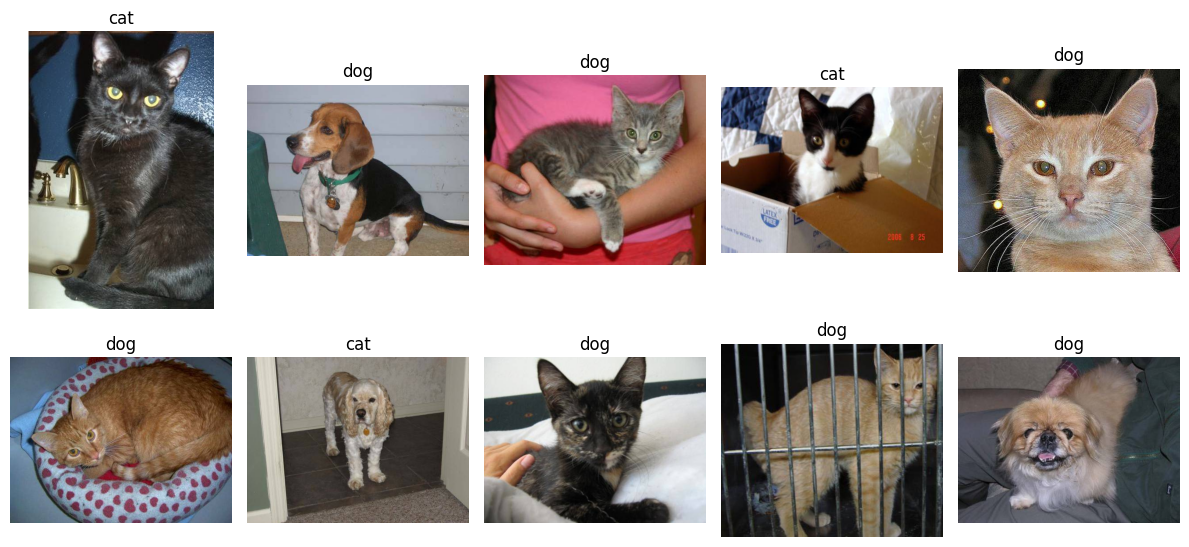

In [11]:
from visualization import display_model_inference
label_dict = {0: "cat", 1: "dog"}
display_model_inference(test_images_filepaths, test_result_df, label_dict,cols=5)

## 6.2 AlexNet
- LeNet-5와 비슷하지만, GPU 2개를 기반으로 한 병렬 구조

In [3]:
cat_dir_path = r"./080289/chap06/data/dogs-vs-cats/Cat/"
dog_dir_path = r"./080289/chap06/data/dogs-vs-cats/Dog/"

cat_image_path_list = sorted(
    [ os.path.join(cat_dir_path,cat_image_name) for cat_image_name in os.listdir(cat_dir_path)]
)
dog_image_path_list = sorted(
    [ os.path.join(dog_dir_path,dog_image_name) for dog_image_name in os.listdir(dog_dir_path)]
)
total_image_path_list = [*cat_image_path_list,*dog_image_path_list]
correct_image_path_list = [
    image_file_path for image_file_path in total_image_path_list if cv2.imread(image_file_path) is not None
]

random.seed(42)
random.shuffle(correct_image_path_list )
train_images_filepaths = correct_image_path_list[:400]
val_images_filepaths = correct_image_path_list[400:-10]
test_images_filepaths = correct_image_path_list[-10:]
print(
    f"train 데이터 개수 : {len(train_images_filepaths)}"
    f"\ntest 데이터 개수 : {len(val_images_filepaths)}"
    f"\nval 데이터 개수 : {len(test_images_filepaths)}"
)

train 데이터 개수 : 400
test 데이터 개수 : 92
val 데이터 개수 : 10


In [5]:
from dataset.cat_vs_dog_dataset import DogvsCatDataset
from preprocess.image_transform import ImageTransform

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(
    train_images_filepaths, transform=ImageTransform(size, mean, std), phase="train"
)
val_dataset = DogvsCatDataset(
    val_images_filepaths, transform=ImageTransform(size, mean, std), phase="val"
)

index = 0
train_image_size = train_dataset.__getitem__(index)[0].size()
train_image_label = train_dataset.__getitem__(index)[1]
print(f"train 이미지 사이즈 : {train_image_size}\ntrain 이미지 label: {train_image_label}")

train 이미지 사이즈 : torch.Size([3, 224, 224])
train 이미지 label: 0


In [6]:
from data import load_data_using_mini_batch, make_data_loader_dict
batch_size = 32

train_dataloader = load_data_using_mini_batch(train_dataset, batch_size, shuffle=True)
val_dataloader = load_data_using_mini_batch(val_dataset, batch_size, shuffle=False)
dataloader_dict = make_data_loader_dict(train_dataloader,val_dataloader)

input,label = next(iter(train_dataloader))
input_in_batch_size = input.size()
label_in_batch_size = label.size()
print(f"train batch 데이터 사이즈: {input_in_batch_size}\ntrain batch 레이블 사이즈: {label_in_batch_size}")

train batch 데이터 사이즈: torch.Size([32, 3, 224, 224])
train batch 레이블 사이즈: torch.Size([32])


In [8]:
from models.alexnet import AlexNet

model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
from torchsummary import summary
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [10]:
from train import train_model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch,device)

Epoch 1/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6941 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6941 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6938 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6938 Acc: 0.4891
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6937 Acc: 0.4891
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6935 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6934 Acc: 0.4891
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.4891
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.4891
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5326
Training complete in 1m 16s
Best val Acc: 0.532609


In [11]:
from test import make_test_result_dataframe


test_result_df = make_test_result_dataframe(test_images_filepaths,size,mean,std,model,device)
test_result_df.head(10)

  0%|          | 0/10 [00:00<?, ?it/s]

,id,label
0,145,0.499328
1,211,0.499780
2,162,0.499671
3,200,0.500440
4,210,0.499954
5,224,0.499304
6,213,0.499758
7,109,0.500320
8,15,0.499227
9,167,0.499345


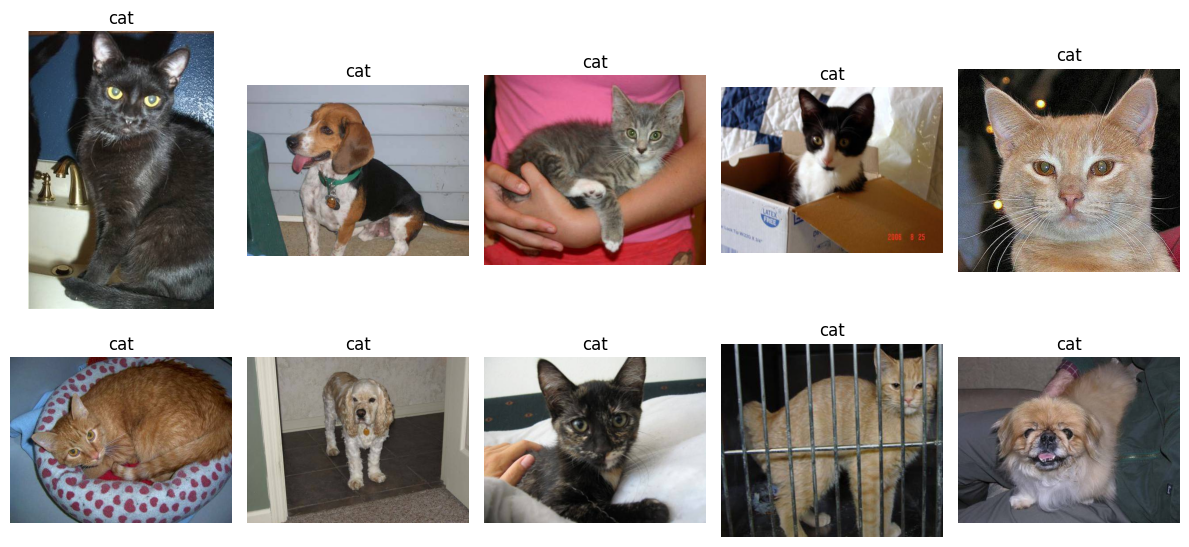

In [12]:
from visualization import display_model_inference
label_dict = {0: "cat", 1: "dog"}
display_model_inference(test_images_filepaths, test_result_df, label_dict,cols=5)

## 6.1.3 VGGNet
- 합성곱의 파라미터 수를 줄이고 훈련시간을 개선하려고 탄생
- 네트워크를 깊게 만드는 것이 성능에 어떤 영향을 미치는 지 확인하고 자 나온 것
    - 깊이의 영향만 보고자, 필터&커널의 크기를 가장 작은 3*3으로 고정

In [8]:
from models.vgg_layer import VGGLayer

vgglayer = VGGLayer()
vgg_11_layer = vgglayer.get_vgg_layers(vgglayer.vgg11_config,True)
print(vgg_11_layer)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [9]:
from models.vggnet import VGG


OUTPUT_DIM = 2
model = VGG(vgg_11_layer, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [5]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [6]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
train_path = "./080289/chap06/data/catanddog/train"
test_path = "./080289/chap06/data/catanddog/test"

train_dataset = torchvision.datasets.ImageFolder(train_path, transform=train_transforms)

test_dataset = torchvision.datasets.ImageFolder(test_path, transform=test_transforms)

VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = random_split(
    train_dataset, [n_train_examples, n_valid_examples]
)
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_dataset)}")
BATCH_SIZE = 128
train_iterator = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [12]:
import time

from test import evaluate

from train import train_vgg
from utils import epoch_time


EPOCHS = 5
best_valid_loss = float("inf")
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train_vgg(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "./080289/chap06/data/VGG-model.pt")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 1m 29s
	Train Loss: 0.705 | Train Acc: 46.84%
	 Valid. Loss: 0.694 |  Valid. Acc: 45.28%
Epoch: 02 | Epoch Time: 1m 29s
	Train Loss: 0.692 | Train Acc: 51.51%
	 Valid. Loss: 0.694 |  Valid. Acc: 45.28%
Epoch: 03 | Epoch Time: 1m 28s
	Train Loss: 0.695 | Train Acc: 52.04%
	 Valid. Loss: 0.694 |  Valid. Acc: 45.28%
Epoch: 04 | Epoch Time: 1m 28s
	Train Loss: 0.697 | Train Acc: 50.93%
	 Valid. Loss: 0.693 |  Valid. Acc: 43.40%
Epoch: 05 | Epoch Time: 1m 29s
	Train Loss: 0.693 | Train Acc: 53.62%
	 Valid. Loss: 0.693 |  Valid. Acc: 54.72%


## 6.1.4 GoogleNet
- 주어진 하드웨어 자원을 최대한 효율적으로 이용하면서 학습 능력은 극대화할 수 있는 깊고 넓은 신경망
- sparse-connectivity 사용

## 6.1.5 ResNet
- Residual Block 을 사용하여, 기울기가 잘 전파될 수 있도록 숏컷 사용